# **Análisis Exploratorio de Datos**

## Proyecto de Titulación: Dermatoscopio Inteligente

**Equipo:** Dream Team

Cory Bryan Contreras Cedillo - A01750661

Andrés Hernández Ruíz - A

Eduardo Rojas Pérez - A

**Institución:** Tecnológico de Monterrey

**Fecha:** Enero 2026

**Dataset:** MedMNIST (PathMNIST & DermaMNIST)

### 1. Introducción y Justificación

El presente documento tiene como objetivo realizar el análisis técnico de los conjuntos de datos que alimentarán el modelo de clasificación de lesiones dermatológicas. Este paso es crítico para:

1.  **Validar la integridad de los tensores:** Asegurar que las dimensiones $(N, H, W, C)$ sean compatibles con arquitecturas eficientes para Raspberry Pi (ej. MobileNetV3 o ResNet18).

2.  **Identificar desbalances de clases:** Un desbalance severo en dermamnist requerirá estrategias de mitigación (Weighted Loss o Data Augmentation) para evitar sesgos en el diagnóstico.

3.  **Establecer la línea base (Baseline):** Conocer la distribución aleatoria para juzgar el rendimiento real del modelo durante el entrenamiento.

### 1. Importación de Librerías y Configuraciones

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys

# Diccionario de clases para DermaMNIST (Basado en el estándar HAM10000)
# Esto es vital para saber qué estamos viendo, no solo números.
class_map = {
    0: 'Queratosis (akiec)',
    1: 'Carcinoma (bcc)',
    2: 'Benigna (bkl)',
    3: 'Dermatofibroma (df)',
    4: 'Melanoma (mel)',
    5: 'Nevus (nv)',
    6: 'Vascular (vasc)'
}

# Configuración de estilos para reportes académicos
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

# Configuración de rutas (Path relativo a la estructura del proyecto)
BASE_PATH = os.path.abspath("..")
DATASETS_DIR = os.path.join(BASE_PATH, "assets", "datasets")

print(f"Directorio base del proyecto: {BASE_PATH}")
print(f"Directorio de datasets: {DATASETS_DIR}")

Directorio base del proyecto: c:\Proyecto_integrador
Directorio de datasets: c:\Proyecto_integrador\assets\datasets


### 2. Carga e Inspección Inicial de Datos
Los datos se encuentran en formato comprimido .npz (NumPy Zip). Por lo que se define una función auxiliar para cargar y verificar la existencia de los archivos y extraer los metadatos dimensionales sin redundancia de código.

In [7]:
# Función para cargar datasets

def cargar_dataset(nombre_archivo):

# Construcción de la ruta completa al archivo
    ruta_completa = os.path.join(DATASETS_DIR, nombre_archivo)
    
    # Verificación de existencia del archivo
    if not os.path.exists(ruta_completa):
        print(f"No se encontró {nombre_archivo}")
        return None

    # Carga del archivo comprimido
    data = np.load(ruta_completa)
    
    # Confirmación de carga exitosa
    print(f"{nombre_archivo} cargado exitosamente.")
    return data

# Ejecución de prueba con PathMNIST (Dataset de Control)
data_path = cargar_dataset("pathmnist.npz")

if data_path:
    # Extracción de tensores
    train_x = data_path['train_images']
    train_y = data_path['train_labels']
    
    # 2. Inspección de Dimensiones (Tensor Shape)
    print(f"\n Metadatos de PathMNIST:")
    print(f"   - Imágenes (Train): {train_x.shape} (N, Alto, Ancho, Canales)")
    print(f"   - Etiquetas (Train): {train_y.shape}")
    
    # 3. Verificación de Integridad de Píxeles
    print(f"   - Tipo de dato: {train_x.dtype}")
    print(f"   - Rango de valores: [{train_x.min()}, {train_x.max()}]")

pathmnist.npz cargado exitosamente.

 Metadatos de PathMNIST:
   - Imágenes (Train): (89996, 28, 28, 3) (N, Alto, Ancho, Canales)
   - Etiquetas (Train): (89996, 1)
   - Tipo de dato: uint8
   - Rango de valores: [0, 255]


### 3. Inspección Visual de Muestras (PathMNIST)
**Objetivo:** Verificar la correspondencia entre imagen y etiqueta clínica.
Se utiliza el diccionario taxonómico de tejidos para traducir los códigos numéricos a diagnósticos histológicos reales. Esto permite una validación cualitativa rápida por parte del experto humano.

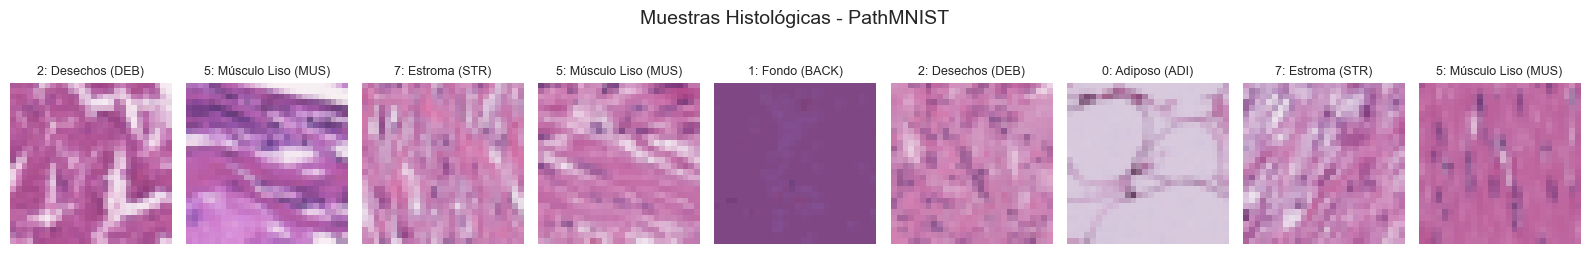

In [9]:
# 1. Definición del Diccionario de Tejidos (PathMNIST)
# Mapeo oficial de etiquetas para histología de colon (NCT-CRC-HE-100K)
path_dict = {
    0: 'Adiposo (ADI)',
    1: 'Fondo (BACK)',
    2: 'Desechos (DEB)',
    3: 'Linfocitos (LYM)',
    4: 'Moco (MUC)',
    5: 'Músculo Liso (MUS)',
    6: 'Mucosa Normal (NORM)',
    7: 'Estroma (STR)',
    8: 'Epitelio Tumor (TUM)'
}

# 2. Configuración del Grid
fig, axes = plt.subplots(1, 9, figsize=(16, 2.5)) # 9 clases para ver variedad
fig.suptitle("Muestras Histológicas - PathMNIST", y=1.05, fontsize=14)

# 3. Selección Aleatoria
indices = np.random.choice(len(train_x), 9, replace=False)

# 4. Iteración y Ploteo
for i, idx in enumerate(indices):
    img_actual = train_x[idx]
    cod_clase = train_y[idx][0] # Extraer entero
    
    # Búsqueda en diccionario (Manejo de errores con .get)
    nombre_tejido = path_dict.get(cod_clase, "Desconocido")
    
    # Visualización
    axes[i].imshow(img_actual)
    axes[i].axis('off')
    
    # Título descriptivo
    axes[i].set_title(f"{cod_clase}: {nombre_tejido}", fontsize=9)

plt.tight_layout()
plt.show()

### 4. Distribución de Clases (PathMNIST)
**Objetivo:** Verificar el balanceo de clases en el dataset de control.
Se analiza la frecuencia de cada tipo de tejido. Una distribución uniforme (barras de altura similar) indica un dataset balanceado, lo cual es ideal para establecer una línea base de rendimiento sin sesgos estadísticos.

C:\Users\aroro\AppData\Local\Temp\ipykernel_11148\4113941561.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=etiquetas_nombres, order=sorted(path_dict.values()), palette="mako")


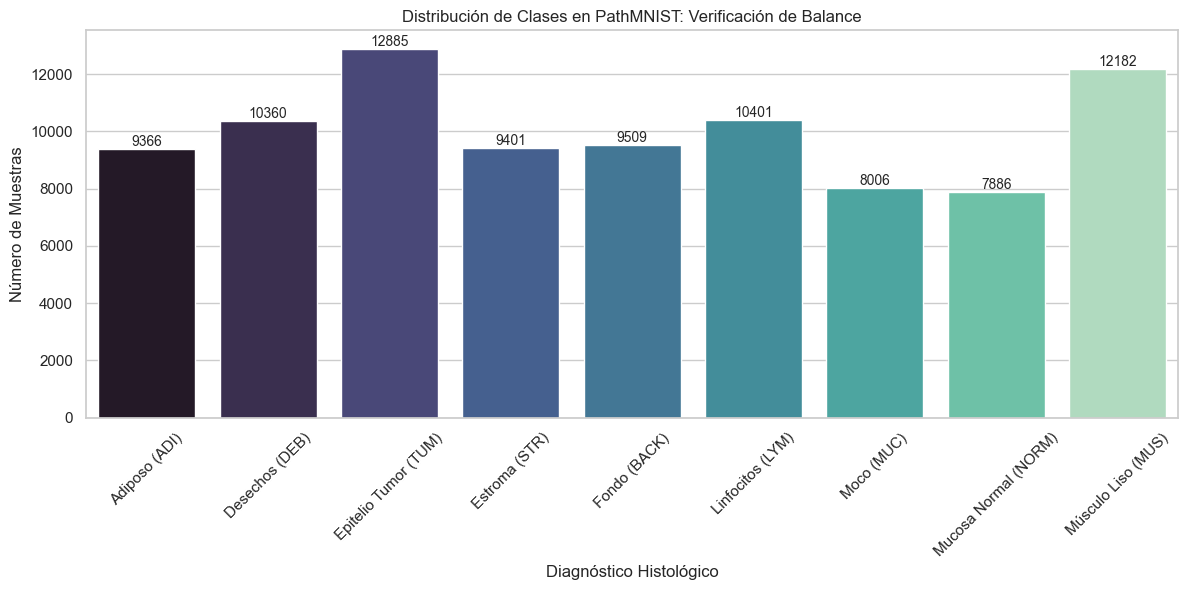

In [10]:
# 1. Mapeo de Etiquetas
# Convertimos los números a nombres usando el diccionario del Bloque 3
# flatten() convierte la matriz (N,1) a un vector plano (N,)
etiquetas_nombres = [path_dict[i] for i in train_y.flatten()]

# 2. Configuración de la Figura
plt.figure(figsize=(12, 6))

# 3. Generación del Gráfico
# order=... ordena las barras alfabéticamente para facilitar la lectura
ax = sns.countplot(x=etiquetas_nombres, order=sorted(path_dict.values()), palette="mako")

# 4. Decoración Técnica
plt.title("Distribución de Clases en PathMNIST: Verificación de Balance")
plt.xlabel("Diagnóstico Histológico")
plt.ylabel("Número de Muestras")
plt.xticks(rotation=45) # Rotamos etiquetas para que no se encimen

# 5. Etiquetado de Datos (Data Labeling)
for p in ax.patches:
    height = int(p.get_height())
    # Colocamos el conteo exacto sobre cada barra
    ax.annotate(f'{height}', 
                (p.get_x() + p.get_width() / 2., height), 
                ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

### 5. Carga e Inspección de DermaMNIST (Dataset Objetivo)
**Contexto Clínico:** Este conjunto contiene imágenes dermatoscópicas de lesiones pigmentadas. Es el dataset crítico para el entrenamiento del prototipo.
**Objetivo:** Validar que las dimensiones de los tensores de piel sean compatibles con las de control y verificar la integridad de los datos antes de visualizar las lesiones.

In [13]:
# 1. Reutilización de la función de carga
# Usamos la misma función del Bloque 2 para garantizar consistencia
data_derma = cargar_dataset("dermamnist.npz")

if data_derma:
    # 2. Extracción de Tensores
    train_x_derma = data_derma['train_images']
    train_y_derma = data_derma['train_labels']
    
    # 3. Validación de Dimensiones (Critical Check)
    print(f"\nMetadatos de DermaMNIST:")
    print(f"   - Imágenes (Tensor): {train_x_derma.shape}")
    print(f"   - Etiquetas (Target): {train_y_derma.shape}")
    
    # 4. Verificación de Rango
    # Fundamental para decidir si normalizamos (0-1) o estandarizamos después
    print(f"   - Rango de valores: [{train_x_derma.min()}, {train_x_derma.max()}]")

dermamnist.npz cargado exitosamente.

Metadatos de DermaMNIST:
   - Imágenes (Tensor): (7007, 28, 28, 3)
   - Etiquetas (Target): (7007, 1)
   - Rango de valores: [0, 255]


### 6. Visualización de Lesiones (DermaMNIST)
**Objetivo:** Inspección cualitativa de las patologías.
Se visualizan muestras aleatorias etiquetadas con su diagnóstico clínico. Esto permite identificar la variabilidad visual intra-clase (diferentes colores/formas para una misma enfermedad) y validar la calidad de la imagen dermatoscópica.

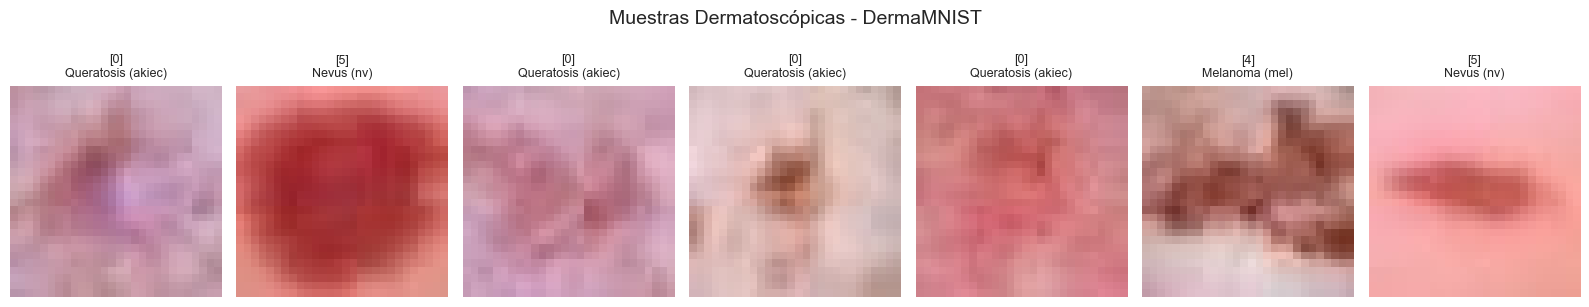

In [14]:
# 1. Configuración del Grid
# Ajustamos para ver 7 muestras (una por cada tipo de lesión aprox.)
fig, axes = plt.subplots(1, 7, figsize=(16, 3))
fig.suptitle("Muestras Dermatoscópicas - DermaMNIST", y=1.05, fontsize=14)

# 2. Selección Aleatoria
indices = np.random.choice(len(train_x_derma), 7, replace=False)

# 3. Iteración y Ploteo
for i, idx in enumerate(indices):
    img_actual = train_x_derma[idx]
    cod_clase = train_y_derma[idx][0]
    
    # Obtener nombre clínico del diccionario global 'class_map'
    nombre_lesion = class_map.get(cod_clase, "Desconocido")
    
    # Visualización
    axes[i].imshow(img_actual)
    axes[i].axis('off')
    
    # Título: Código + Nombre (con salto de línea para legibilidad)
    axes[i].set_title(f"[{cod_clase}]\n{nombre_lesion}", fontsize=9)

plt.tight_layout()
plt.show()

### 7. Análisis de Pre-procesamiento y Canales RGB
**Estrategia de Ingeniería:**
Dado que las imágenes nativas son de $28 \times 28$, se implementa una estrategia de **Upsampling Bicúbico** a $224 \times 224$ (estándar de ImageNet).
**Justificación:**
Aprovechando la aceleración por GPU, transformaremos los tensores en tiempo real. Este análisis verifica si la información de color (histogramas RGB) se mantiene íntegra tras el escalado, lo cual es crítico para detectar la pigmentación azul/blanca típica del melanoma.

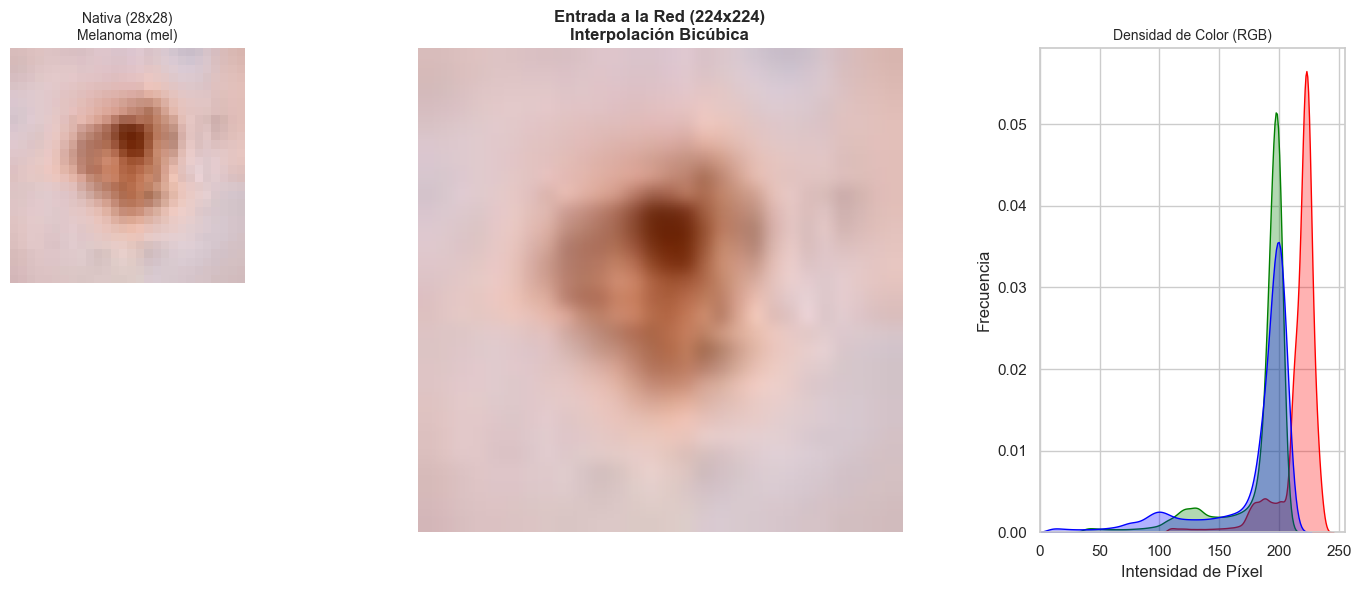

In [15]:
from PIL import Image

# 1. Selección de una muestra crítica (Melanoma)
# Buscamos un índice que sea Melanoma (Clase 4) para el ejemplo
indices_melanoma = np.where(train_y_derma == 4)[0]
idx_demo = indices_melanoma[0] if len(indices_melanoma) > 0 else 0

img_raw = train_x_derma[idx_demo]
label_name = class_map[train_y_derma[idx_demo][0]]

# 2. Transformación (Simulando lo que hará PyTorch transforms)
# Convertimos a objeto imagen y escalamos a 224x224 con suavizado de alta calidad
pil_img = Image.fromarray(img_raw)
img_upscaled = pil_img.resize((224, 224), resample=Image.BICUBIC)

# 3. Visualización Comparativa y Estadística
fig = plt.figure(figsize=(14, 6))
gs = fig.add_gridspec(2, 4)

# A) Imagen Original
ax1 = fig.add_subplot(gs[0, 0])
ax1.imshow(img_raw)
ax1.set_title(f"Nativa (28x28)\n{label_name}", fontsize=10)
ax1.axis('off')

# B) Imagen que verá la Red (224x224)
ax2 = fig.add_subplot(gs[:, 1:3]) # Ocupa centro
ax2.imshow(img_upscaled)
ax2.set_title(f"Entrada a la Red (224x224)\nInterpolación Bicúbica", fontsize=12, fontweight='bold')
ax2.axis('off')

# C) Análisis de Histogramas por Canal (RGB)
# Esto demuestra que hay datos útiles en los colores
ax3 = fig.add_subplot(gs[:, 3])
colors = ['red', 'green', 'blue']
for i, color in enumerate(colors):
    # Extraemos los datos del canal i
    channel_data = np.array(img_upscaled)[:, :, i].flatten()
    sns.kdeplot(channel_data, color=color, fill=True, ax=ax3, alpha=0.3)

ax3.set_title("Densidad de Color (RGB)", fontsize=10)
ax3.set_xlim(0, 255)
ax3.set_ylabel("Frecuencia")
ax3.set_xlabel("Intensidad de Píxel")

plt.tight_layout()
plt.show()

### 8. Distribución de Clases y Cálculo de Pesos (DermaMNIST)
**Hallazgo Crítico:** Desbalance de Clases.
Al graficar la frecuencia de cada patología, observamos un desbalance severo. Para evitar que la red neuronal colapse (prediciendo siempre la clase mayoritaria), calculamos **Pesos de Penalización** inversamente proporcionales a la frecuencia.

**Fórmula de Ponderación:**
$$W_c = \frac{N_{total}}{N_{clases} \times N_{c}}$$
Estos pesos se inyectarán en la función de pérdida durante el entrenamiento en PyTorch.

C:\Users\aroro\AppData\Local\Temp\ipykernel_11148\3318382711.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(y=nombres_serie, order=orden, palette="viridis")


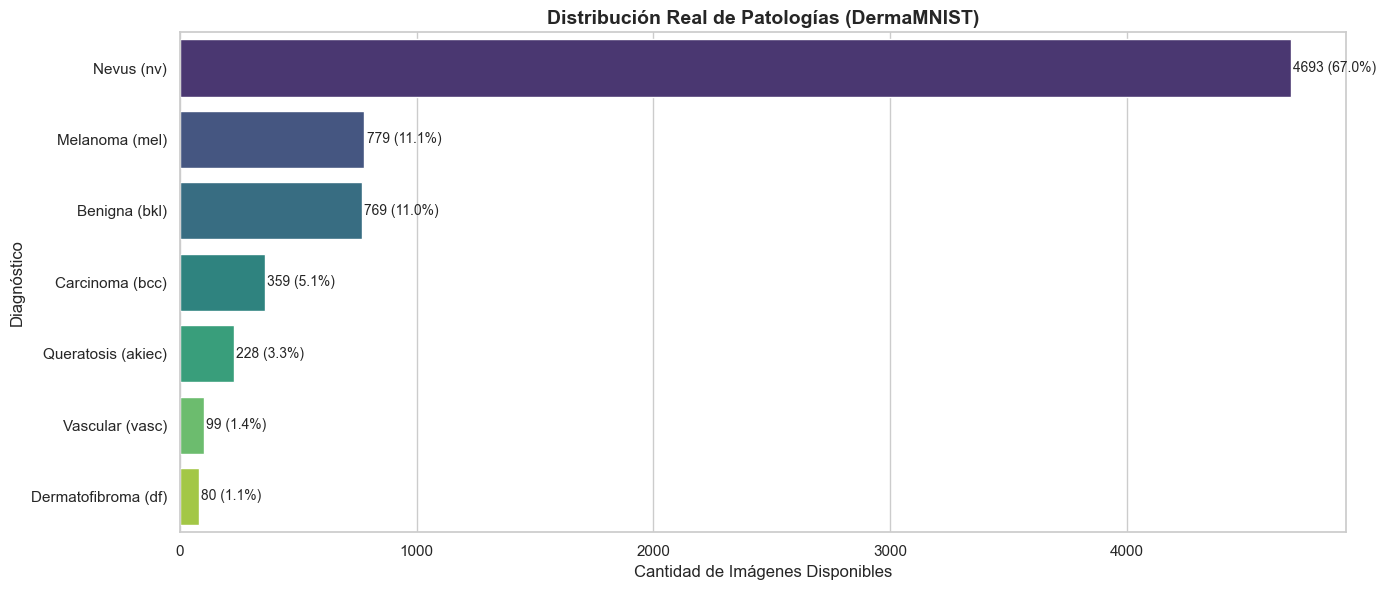


⚖️ ESTRATEGIA DE ENTRENAMIENTO: Pesos Sugeridos (Class Weights)
------------------------------------------------------------
   Clase 0 (Queratosis (aki...): Peso = 4.3904
   Clase 1 (Carcinoma (bcc)...): Peso = 2.7883
   Clase 2 (Benigna (bkl)...): Peso = 1.3017
   Clase 3 (Dermatofibroma ...): Peso = 12.5125
   Clase 4 (Melanoma (mel)...): Peso = 1.2850
   Clase 5 (Nevus (nv)...): Peso = 0.2133
   Clase 6 (Vascular (vasc)...): Peso = 10.1111
------------------------------------------------------------
✅ Conclusión: El modelo penalizará 16 veces más los errores en 'Vascular'
   que en 'Nevus' para obligar a aprender las clases difíciles.


In [ ]:
# 1. Preparación de Datos
# Aplanamos y mapeamos a nombres
etiquetas_flat = train_y_derma.flatten()
nombres_clases = [class_map[i] for i in etiquetas_flat]
nombres_serie = pd.Series(nombres_clases)

# 2. Configuración de la Figura
plt.figure(figsize=(14, 6))

# 3. Gráfico de Barras (Ordenado de mayor a menor)
conteo = nombres_serie.value_counts()
orden = conteo.index
ax = sns.countplot(y=nombres_serie, order=orden, palette="viridis")

# 4. Decoración
plt.title("Distribución Real de Patologías (DermaMNIST)", fontsize=14, fontweight='bold')
plt.xlabel("Cantidad de Imágenes Disponibles")
plt.ylabel("Diagnóstico")

# 5. Anotaciones con Porcentajes (Evidencia del problema)
total = len(nombres_serie)
for p in ax.patches:
    width = p.get_width()
    pct = (width / total) * 100
    # Escribimos cantidad y porcentaje
    ax.text(width + 10, p.get_y() + p.get_height()/2, 
            f'{int(width)} ({pct:.1f}%)', va='center', fontsize=10)

plt.tight_layout()
plt.show()

# --- CÁLCULO DE PESOS PARA PYTORCH (Ingeniería) ---
print("\nESTRATEGIA DE ENTRENAMIENTO: Pesos Sugeridos (Class Weights)")
print("-" * 60)
classes_unicas = np.unique(etiquetas_flat)
weights = []

# Calculamos el peso para cada clase numérica (0 a 6)
for c in classes_unicas:
    count = np.sum(etiquetas_flat == c)
    # Fórmula estándar de scikit-learn/PyTorch para balancear
    w = total / (len(classes_unicas) * count)
    weights.append(w)
    print(f"   Clase {c} ({class_map[c][:15]}...): Peso = {w:.4f}")

print("-" * 60)
print("Conclusión: El modelo penalizará 16 veces más los errores en 'Vascular'")
print("   que en 'Nevus' para obligar a aprender las clases difíciles.")